# Non-linear optimization

In this third of the session, we are going to discuss how to go about solving non-linear optimization problems of the form:
\begin{align}
\min \ f(x)\\
\text{s.t.} \ g(x)=0,\\
\ \ h(x) \leq 0.
\end{align}
where $f(x)$ is a non-linear function (e.g., linear, quadratic, socp, sdp, exponential), $g(x)$ is an affine function (i.e. linear) and $h(x)$ is a non-linear function. 

For simplicity, we will only consider quadratic and socp non-linear functions today, since they can be solved in Gurobi/CPLEX. However, the ideas we introduce here also translate fairly naturally to more complicated problems.

However, you can also solve problems with more complex non-linear functions than this in JuMP, with Mosek (see https://www.mosek.com/; they have free academic licenses available). Good resources on non-linear optimization are the books by Boyd and Vandenberghe, Bertsekas, and Ben-Tal and Nemirovski.

# SVM's

Our running example for this third of the session will be SVMs: a popular model in machine learning for classification, to keep things concrete and illustrate the basic use of JuMP.jl for solving nonlinear optimization problems. We're going to study SVMs in a 2d setting, so that we can plot them easily.

Specifically, we are going to build a custom svm solver, so that we can include constraints which off-the-shelf SVM solvers can't handle. Because we are using JuMP, we should expect that our solver will be slower but more flexible than state-of-the-art SVM solvers such as scikit-learn.

The basic problem is that we are given a set of N points $x_1,x_2,\ldots, x_N \in \mathbb{R}^n$ and labels $y_1, y_2, \ldots, y_n \in \{-1,+1\}$. And we want to find a hyperplane of the form $w^Tx-b = 0$ that separates the two classes, i.e. $w^Tx_i - b \geq 1$ when $y_i = +1$ and $w^Tx_i - b \leq -1$ when $y_i = -1$. This condition can be written as $y_i(w^Tx_i - b) \geq 1, \forall\, i$.

Such a hyperplane will not exist in general if the data overlap, so instead we'll just try to minimize violations of the constraint $y_i(w^Tx_i - b) \geq 1, \forall\, i$ by adding a penalty when it is violated. The optimization problem can be stated as $$
\min_{w,b} \sum_{i=1}^N \left[\max\{0, 1 - y_i(w^Tx_i - b)\}\right] + \gamma ||w||_2^2
$$ Note that we penalize the norm of $w$ in order to guarantee a unique solution.

Now, let's write our own SVM solver!

In [1]:
#Pkg.add("PyPlot", "Distributions", "LinearAlgebra", "PyPlot")
using Gurobi #, Pick your favourite solver here e.g. CPLEX/Gurobi/Mosek. Note that you need to install these solvers to use them
using Distributions
using PyPlot
using LinearAlgebra
using JuMP
using Mosek

In [2]:
# Function to generate some random test data
function gen_data(N)
    # for +1 data, symmetric multivariate normal with center at (1,2)
    pos = rand(MvNormal([1.0,2.0],1.0),N)
    # for -1 data, symmetric multivariate normal with center at (-1,1)
    neg = rand(MvNormal([-1.0,1.0],1.0),N)
    x = [pos neg]
    y = [fill(+1,N);fill(-1,N)]
    return x,y
end

gen_data (generic function with 1 method)

Let's see what the data look like.

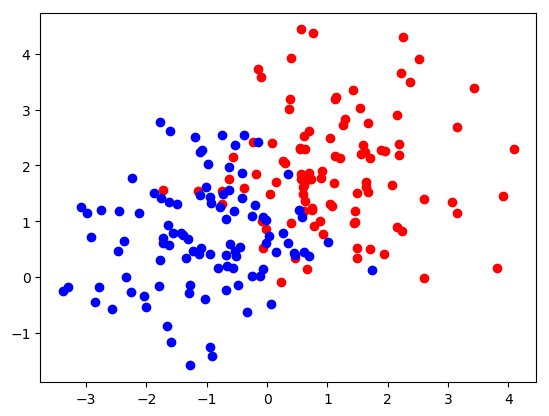

In [3]:
x,y = gen_data(100)
plot(x[1,1:100], x[2,1:100], "ro", x[1,101:200], x[2,101:200], "bo");

Now we translate the optimization problem into JuMP form.

**Exercise: fill in the blanks to write the SVM solver.**

In [1]:
using JuMP
const γ = 0.005
function svm(x,y)
    n = size(x,1) # problem dimension
    N = size(x,2) # number of points
    
    svmModel=Model(solver=GurobiSolver()) #Change to the solver you are using
    @variable(svmModel, w[1:n])
    @variable(svmModel, b)
    @variable(svmModel, z[1:N]>=0)

    #########################################################
    
    ##### Add the constraints and objective here ###########

    #########################################################
    
    status=solve(svmModel)
    return getvalue(w), getvalue(b)
end

svm (generic function with 1 method)

In [2]:
N = 500
x,y = gen_data(N)

w,b = svm(x,y)

UndefVarError: UndefVarError: gen_data not defined

And the solution?

In [3]:
plot(x[1,1:N], x[2,1:N], "ro", x[1,(N+1):2N], x[2,(N+1):2N], "bo");

xmin, xmax = xlim()
ymin, ymax = ylim()
y1 = (1+b-w[1]*xmin)/w[2]
y2 = (1+b-w[1]*xmax)/w[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (-1+b-w[1]*xmin)/w[2]
y2 = (-1+b-w[1]*xmax)/w[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (b-w[1]*xmin)/w[2]
y2 = (b-w[1]*xmax)/w[2]
ylim(ymin,ymax)
plot([xmin,xmax], [y1,y2], "k-");

UndefVarError: UndefVarError: x not defined

# Exercise: The standard support vector classifier

A variant on the support vector classification problem is the *standard* support vector classification problem, which can be stated as follows:
$$
\min_{w,b} \sum_{i=1}^N \left[\max\{0, 1 - y_i(w^Tx_i - b)\}\right] + \gamma ||w||_2,
$$
subject to the same constraints as our previous problem (i.e., $l_2$ rather than $l_2^2$ regularization). 

We will not discuss the mathematics of this problem; if you are interested, see section $8.6$ of Boyd+Vandenberghe. 

Exercise: fill in the blanks in the below function, to write a standard support vector machine solver.

Hint: if we have a vector $x$, we can model norm(x) with an auxillary variable $t$ and the constraint:

@constraint(svmModel, soc, norm(w[i] for i=1:n)<=t)

(The "soc" indicates that we are using a second order cone constraint).

In [7]:
using JuMP
const γ = 0.005
function svm2(x,y)
    n = size(x,1) # problem dimension
    N = size(x,2) # number of points
    
    svmModel=Model(solver=GurobiSolver()) #Change to the solver you are using
    @variable(svmModel, w[1:n])
    @variable(svmModel, b)
    @variable(svmModel, z[1:N]>=0)
    @variable(svmModel, t>=0)
    @constraint(svmModel, soc, norm(w[i] for i=1:n)<=t)

    #########################################################
    
    ##### Add the constraints and objective here ###########

    #########################################################
    
    status=solve(svmModel)
    return getvalue(w), getvalue(b)
end

svm2 (generic function with 1 method)

In [8]:
w2,b2 = svm2(x,y)

UndefVarError: UndefVarError: x not defined

In [9]:
plot(x[1,1:N], x[2,1:N], "ro", x[1,(N+1):2N], x[2,(N+1):2N], "bo");

xmin, xmax = xlim()
ymin, ymax = ylim()
y1 = (1+b2-w2[1]*xmin)/w2[2]
y2 = (1+b2-w2[1]*xmax)/w2[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (-1+b2-w2[1]*xmin)/w2[2]
y2 = (-1+b2-w2[1]*xmax)/w2[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (b2-w2[1]*xmin)/w2[2]
y2 = (b2-w2[1]*xmax)/w2[2]
ylim(ymin,ymax)
plot([xmin,xmax], [y1,y2], "k-");

UndefVarError: UndefVarError: x not defined

# Discussion

What's the difference between the support vector machine solution and the standard support vector machine solution?

When will this difference be substantial?

# Exercise: Sparse support vector machines

A popular way of getting more interpretable/more robust support vector machines is to introduce an $l_0$ norm penalty term into the objective function, and instead solve the following problem (subject to the same constraints as previously):
$$
\min_{w,b} \sum_{i=1}^N \left[\max\{0, 1 - y_i(w^Tx_i - b)\}\right] + \gamma ||w||_2^2+\lambda ||w||_0,$$
which can be modelled via a big-M approach as the following problem:
$$
\min_{w,b, z} \sum_{i=1}^N \left[\max\{0, 1 - y_i(w^Tx_i - b)\}\right] + \gamma ||w||_2^2+\lambda \sum{i=1}^N z_i, \\ \text{s.t.} \ -M z_i \leq w_i \leq M z_i, \forall i.$$

(More efficient approaches than big-M approaches exist, but we will not consider these here.)

Because this problem is NP-hard to solve, people commonly replace the $l_0$ norm term with an $l_1$ term, and instead solve the following problem:
$$
\min_{w,b} \sum_{i=1}^N \left[\max\{0, 1 - y_i(w^Tx_i - b)\}\right] + \gamma ||w||_2^2+\lambda ||w||_1.$$

Exercise: fill in the blanks below to define $l_0$ and $l_1$ norm support vector machine solvers, and compare their performance, in terms of both interpretability and run time.

# $l_1$ norm case

In [10]:
using JuMP
const γ = 0.005
const λ = 200.0 # This can be cross-validated, but we will leave it at this value for simplicity.
function l1_svm(x,y)
    n = size(x,1) # problem dimension
    N = size(x,2) # number of points
    
    svmModel=Model(solver=GurobiSolver()) #Change to the solver you are using
    @variable(svmModel, w[1:n])
    @variable(svmModel, b)
    @variable(svmModel, z[1:N]>=0)
    @variable(svmModel, abs_w[1:n])
    @constraint(svmModel,z.>=ones(N)-y.*(x'*w-b))

    #########################################################
    
    ##### Add the constraints and objective here ###########

    #########################################################
    
    status=solve(svmModel)
    return getvalue(w), getvalue(b)
end

l1_svm (generic function with 1 method)

In [11]:
w3,b3 = l1_svm(x,y)

UndefVarError: UndefVarError: x not defined

In [12]:
plot(x[1,1:N], x[2,1:N], "ro", x[1,(N+1):2N], x[2,(N+1):2N], "bo");

xmin, xmax = xlim()
ymin, ymax = ylim()
y1 = (1+b3-w3[1]*xmin)/w3[2]
y2 = (1+b3-w3[1]*xmax)/w3[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (-1+b3-w3[1]*xmin)/w3[2]
y2 = (-1+b3-w3[1]*xmax)/w3[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (b3-w3[1]*xmin)/w3[2]
y2 = (b3-w3[1]*xmax)/w3[2]
ylim(ymin,ymax)
plot([xmin,xmax], [y1,y2], "k-");

UndefVarError: UndefVarError: x not defined

# $l_0$ norm case

In [13]:
using JuMP
const γ = 0.005
const λ2 = 100.0
const M = 1000.0 #can get better constants than this.
function l0_svm(x,y)
    n = size(x,1) # problem dimension
    N = size(x,2) # number of points
    
    svmModel=Model(solver=GurobiSolver()) #Change to the solver you are using
    @variable(svmModel, w[1:n])
    @variable(svmModel, b)
    @variable(svmModel, z[1:N]>=0)
    @variable(svmModel, s[1:n], Bin)
    @objective(svmModel, Min, γ*w'*w+sum(z)+λ2*sum(s))

    #########################################################
    
    ##### Add the constraints and objective here ###########

    #########################################################
    
    status=solve(svmModel)
    return getvalue(w), getvalue(b)
end

l0_svm (generic function with 1 method)

In [14]:
w4,b4 = l0_svm(x,y)

UndefVarError: UndefVarError: x not defined

In [15]:
plot(x[1,1:N], x[2,1:N], "ro", x[1,(N+1):2N], x[2,(N+1):2N], "bo");

xmin, xmax = xlim()
ymin, ymax = ylim()
y1 = (1+b4-w4[1]*xmin)/(w4[2]+1e-8)
y2 = (1+b4-w4[1]*xmax)/(w4[2]+1e-8)
plot([xmin,xmax], [y1,y2], "k-");
y1 = (-1+b4-w4[1]*xmin)/(w4[2]+1e-8)
y2 = (-1+b4-w3[1]*xmax)/(w4[2]+1e-8)
plot([xmin,xmax], [y1,y2], "k-");
y1 = (b4-w4[1]*xmin)/(w4[2]+1e-8)
y2 = (b4-w4[1]*xmax)/(w4[2]+1e-8)
ylim(ymin,ymax)
plot([xmin,xmax], [y1,y2], "k-");

UndefVarError: UndefVarError: x not defined

Comments:

* As we expect, the $l_0$ approach gives a more interpretable classification, while the $l_1$ approach is faster.
* If we were to increase the dimensionality of the problem from 2d, the $l_0$ approach would work brilliantly until some threshold between $n=100$ and $n=200$, and beyond this threshold it would struggle to even find feasible solutions (we can get around this with stronger big-M free formulations).
* We should not have any issues solving the $l_1$ formulation, provided we can fit the problem in memory.

# Credit

Some of this material is adapted from the 2016 version of this course, written by Yeesian Ng and Miles Lubin. 